In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git transformers bitsandbytes "git+https://github.com/salaniz/pycocoevalcap.git"

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.9 MB/s eta 0:00:00


In [ ]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install -q transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [ ]:
!cp -r /content/drive/MyDrive/Olimpiads/nto_hack_2022/V2/data /content/
!unzip -q /content/drive/MyDrive/Olimpiads/nto_hack_2022/V2/videos_train.zip 
!mv videos_train /content/data

!cp -i /content/drive/MyDrive/Olimpiads/nto_hack_2022/V2/config.py /content/
!cp -i /content/drive/MyDrive/Olimpiads/nto_hack_2022/V2/utils.py /content/
!cp -i /content/drive/MyDrive/Olimpiads/nto_hack_2022/V2/model.py /content/

In [ ]:
!cp -r /content/BLIP/configs /content/
!cp -r /content/BLIP/models /content/

### Utils

In [ ]:
from typing import Tuple, Optional, Union
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import cv2
from PIL import Image
from torch.nn import functional as nnf
from tqdm import tqdm
from torch.utils.data import Dataset
import pickle
import sys
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode


class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def image_grid(imgs, rows, cols):
    pils = imgs
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def make_images(imgs):
    w, h = imgs[0].size
    grids = []
    for x in range(len(imgs)):
        grid = Image.new('RGB', size=(w,h))
        grid.paste(imgs[x])
        grids.append(grid)
    return grids



def read_video(path, transform=None, frames_num=1):
    frames = []
    cap = cv2.VideoCapture(path)

    fps = int(cap.get(cv2.CAP_PROP_FPS))

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    N = length // 2 # //(frames_num)

    current_frame = length // 2
    for i in range(length): 

        ret, frame = cap.read(current_frame)

        if ret and i==current_frame and len(frames)<frames_num:
            size = 384, 384
            frame = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            frame.thumbnail(size, Image.ANTIALIAS)

            frames.append(frame)
            current_frame += N

    cap.release()
    return frames


class ClipCocoDataset(Dataset):
    
    def __init__(self, data_path: str,  prefix_length= 50, gpt2_type = "gpt2",
                 normalize_prefix=False):
        # self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        
        #self.image_ids = [caption["image_id"] for caption in captions_raw]
        
        self.captions = captions_raw
        self.transform = transforms.Compose([
        transforms.Resize((384,384),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    
    def __len__(self) -> int:
        return len(self.captions)

    def __getitem__(self, item):
        return self.transform(self.prefixes[item]), self.captions[item][8:-13]

"""

    ВАЛИДАЦИЯ

"""

def filter_ngrams(output_text):
    a_pos = output_text.find(' A:')
    sec_a_pos = output_text.find(' A:', a_pos + 1)
    return output_text[:sec_a_pos]

def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt='',
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.98,
        temperature=1.,
        stop_token = '<|endoftext|>',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if not tokens:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    #print('tokens',tokens)
                    tokens = tokens.unsqueeze(0).to(device)

            emb_tokens = model.gpt.transformer.wte(tokens)

            if embed is not None:
                generated = torch.cat((embed, emb_tokens), dim=1)
            else:
                generated = emb_tokens

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                #
                top_k = 2000
                top_p = 0.98
                #print(logits)
                #next_token = transformers.top_k_top_p_filtering(logits.to(torch.int64).unsqueeze(0), top_k=top_k, top_p=top_p)
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)

                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)

                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())

            output_text = tokenizer.decode(output_list)
            output_text = filter_ngrams(output_text)
            generated_list.append(output_text)

    return generated_list[0]

### Main

In [ ]:
import bitsandbytes as bnb
import gc
import io
import os
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
import cv2
import sys
import requests
from PIL import Image

import torchvision
import transformers
import torch
from torch.nn import functional as nnf
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import autocast
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

# from data.blip.utils import *
from model import *
# from data.blip.config import CFG

from transformers.optimization import Adafactor, AdafactorSchedule
from torch.utils.checkpoint import checkpoint_sequential
import warnings
warnings.simplefilter('ignore')

import time

from BLIP.models.blip import blip_decoder

In [ ]:
class CFG:
    data_p = f"/content/data/blip"
    main_df_path = f'/content/data/train.csv'
    train_df_path = f'{data_p}/new_train.csv'
    valid_df_path = f'{data_p}/new_valid.csv'
    train_features_path = f'{data_p}/Features_train.pkl'
    valid_features_path = f'{data_p}/Features_valid.pkl'
    video_path = f'/content/data/videos_train'
    out_dir = f'/content/drive/MyDrive/Olimpiads/nto_hack_2022/V2'

    model_name = 'blipv1'
    backbone = 'gpt2'
    prefix_length = 35
    
    epochs = 20
    save_every = 1
    batch_size = 16
    learning_rate = 5e-6
    warmup_steps = 5000

In [ ]:
def get_caption(prefix, model, device, tokenizer, prompt=''):
    prefix = prefix.to(device)
    with torch.no_grad():

        prefix_embed = model.clip_project(prefix).reshape(len(prefix), CFG.prefix_length, -1)

        answers = []

        for x in range(len(prefix_embed)):

            start = time.time()

            cur_prefix_embed = prefix_embed[x].unsqueeze(0).to('cpu')
            
            print('first', time.time()-start)
            
            if prompt:
                generated_text_prefix = generate2(model, tokenizer, prompt=prompt, embed=cur_prefix_embed)
            else:
                generated_text_prefix = generate2(model, tokenizer, embed=cur_prefix_embed)
            
            print('second', time.time()-start)
        
            answers.append(generated_text_prefix.replace('\n',' ').replace('<|endoftext|',''))

    return [x[len(prompt):].strip() for x in answers]

# def get_ans(model, clip_emb, prompt, device, tokenizer):
#     output = get_caption(clip_emb, model, device, tokenizer, prompt=prompt)
#     return output

In [ ]:
def train(train_loader, model, optimizer, scheduler, device, epoch):
    loss_avg = AverageMeter()
    
    model = model.to(device)
    model.train()

    progress = tqdm(total=len(train_loader))
    for idx, (image, caption) in enumerate(train_loader):
        model.zero_grad()

        image = image.to(device)

        segments = 2

        with torch.cuda.amp.autocast():
            loss = model(image, caption)  
            loss.backward()    
          
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        loss_avg.update(loss.item(), len(caption)) # mask
        progress.set_description(f"loss: {loss_avg.avg:.5f}")
        progress.update()
        
        torch.clear_autocast_cache()
        torch.cuda.empty_cache()
    progress.close()

    return model


def valid(model, valid_loader, device, gt):
    loss_avg = AverageMeter()
    model.eval()
    progress = tqdm(enumerate(valid_loader), total=len(valid_loader))
    tokenizer = GPT2Tokenizer.from_pretrained(CFG.backbone)
    

    all_answers = []
    for idx, (tokens, mask, prefix) in progress:
        tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.float32)
        answer = get_caption(prefix, model, device, tokenizer, prompt='Caption: ')
        all_answers.append(answer)
    score = bleu_metric(gt, np.concatenate(all_answers))
    return score
    

import nltk
def bleu_metric(ground_truth, prediction):
    scores = []
    for gt, pred in zip(ground_truth, prediction):
        if type(pred)==str and type(gt)==str:
            score = nltk.translate.bleu_score.sentence_bleu([gt.lower().split()], pred.lower().replace('<|endoftext|>','').split(), weights = (0.5, 0.5))
        scores+=[score]
    return np.array(scores).mean()*100

In [ ]:
def main():

    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    valid_df = pd.read_csv(CFG.valid_df_path)
    train_ds = ClipCocoDataset(CFG.train_features_path, CFG.prefix_length)
    valid_ds = ClipCocoDataset(CFG.valid_features_path, CFG.prefix_length)

    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=False)

    model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    model = blip_decoder(pretrained=model_url, image_size=384, vit='base')
    device = torch.device('cuda') # xm.xla_device()

    if not os.path.exists(CFG.out_dir):
        os.makedirs(CFG.out_dir)

    model = model.to(device)
   
    model.train()
    optimizer = AdamW(model.parameters(),lr=2e-6, weight_decay=0.05) # 5e-5

    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=CFG.warmup_steps, num_training_steps=CFG.epochs * len(train_loader))

    for epoch in range(1, 1+CFG.epochs):
        train(train_loader, model, optimizer, scheduler, device, epoch)
        valid(model, valid_loader, device, valid_df.caption.tolist())

        if epoch % CFG.save_every==0:
            torch.save(model.state_dict(),os.path.join(CFG.out_dir, f"{CFG.model_name}.pt"))
    
main()

In [ ]:
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model = blip_decoder(pretrained=model_url, image_size=384, vit='base')

In [ ]:
data_path = '/content/data/blip/Features_train.pkl'
with open(data_path, 'rb') as f:
          all_data = pickle.load(f)

raw_image = all_data['clip_embedding'][0]

transform = transforms.Compose([
        transforms.Resize((384,384),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 

image = transform(raw_image).unsqueeze(0)

In [ ]:
with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

caption: two people standing in front of a christmas tree


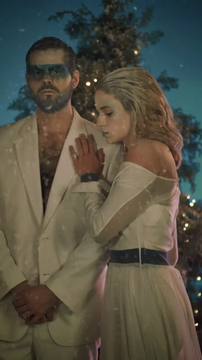

In [ ]:
all_data['clip_embedding'][0]

In [ ]:
all_data['captions'][0]

'Caption: Portrait couple of fashion models with amazing conceptual winter makeup and dressed in white clothes while looking at the camera.<|endoftext|>'

### Validation

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from tqdm import tqdm, trange
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
#from torch.cuda.amp import autocast
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
#from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
#from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
from PIL import Image
import clip

import transformers

from utils import *
from model import *
import re

import warnings
warnings.simplefilter('ignore')

import time

/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [ ]:
def load_demo_image(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

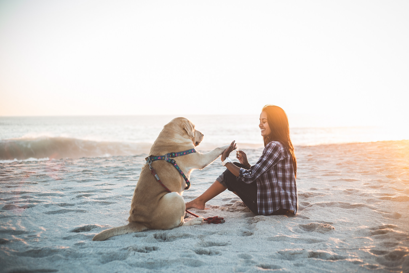

  0%|          | 0.00/1.97G [00:00<?, ?B/s]

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption: a woman and her dog on the beach


In [ ]:
from BLIP.models.blip import blip_decoder
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 384
image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

In [ ]:
def get_caption(prefix, prompt=''):
        prefix = prefix.to(device)
        display(prefix.shape)
        with torch.no_grad():

            prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

            start = time.time()

            if prompt:
                generated_text_prefix = generate2(model, tokenizer, prompt=prompt, embed=prefix_embed)
            else:
                generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)

            print(time.time() - start)

        return generated_text_prefix.replace('\n',' ').replace('<|endoftext|','')

def get_ans(clip_emb, prompt):
        output = get_caption(clip_emb, prompt=prompt)
        ans = output[len(prompt):].strip()
        return {'answer': ans}


#from tqdm import tqdm, trange



# parser = argparse.ArgumentParser()
# parser.add_argument('--input_path', default='./input_test.csv', type=str, help='input path')
# parser.add_argument('--video_path', default='./videos_val/', type=str, help='input path')
# parser.add_argument('--output_path', default='./output/', type=str, help='config path')
# args = parser.parse_args()

config = dict(
        model_path = '/content/drive/MyDrive/Olimpiads/nto_hack_2022/V2/v2_1.pt',
        video_path = '/content/data/videos_train/',
        val_path = '/content/data/new_valid.csv',
        gpt = 'gpt2',
        prefix_len = 35
    )


prefix_length = config['prefix_len']#40

device = 'cuda'
clip_model, preprocess = clip.load("ViT-L/14@336px", device=device, jit=False)
clip_model.to(device)

tokenizer = GPT2Tokenizer.from_pretrained(config['gpt'])


model_path = config['gpt']
model = ClipCaptionModel(prefix_length = prefix_length, backbone = config['gpt'])

model.load_state_dict(torch.load(config['model_path'], map_location='cpu'))
model.to(device)

out_path = 'Features_val.pkl'


val_embeddings = []
val_captions = []

input_test = pd.read_csv(config['val_path'])

c = 0
for p in tqdm(input_test.paths):
         #print(p)
         #n= df_eval.iloc[i, 0]#, df_eval.iloc[i, 1]
    text = f'Caption:'
    path = f'{config["video_path"]}{p}'
    try:
        video = read_video(path, transform=None,frames_num=1)

        i = image_grid(video,1,1)
        image = preprocess(i).unsqueeze(0).to(device)

        # image = make_images(video)
        # new_images = []
        # for img in image:
        #     new_images.append(preprocess(img).unsqueeze(0))

        with torch.no_grad():
            prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
            # prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        val_embeddings.append(prefix)
        val_captions.append(text)
    except Exception as e:
        print(e)

    c+=1
    if c > 50:
        break

answers = []
for i in tqdm(range(len(val_embeddings))):
        emb = val_embeddings[i]

        #qid = df_eval.iloc[i, 2]
        ans = get_ans(emb, 'Caption: ')
        answers.append(ans['answer'])


df = pd.DataFrame({'captions':answers})
df.to_csv('/content/data/answer.csv', index=False)

In [ ]:
path_pred = '/content/data/answer.csv'
df_pred = pd.read_csv(path_pred)
new_preds = []
for x in df_pred['captions']:
    a = ''
    if x is not np.nan:
        for y in x:
            if re.findall(r'[A-Za-z0-9 \.\,\-]', y):
                a += y
    new_preds.append(a)
df_pred['captions'] = new_preds
df_pred.to_csv('/content/data/new_answer.csv', index=False)

In [ ]:
import pandas as pd
import nltk
import numpy as np

path_gt = '/content/data/new_valid.csv'
path_pred = '/content/data/answer.csv'
df_eval = pd.read_csv(path_gt)
df_pred = pd.read_csv(path_pred)
scores = []
for pred, gt in zip(df_eval.caption, df_pred.captions):
    if type(pred)==str and type(gt)==str:
        score = nltk.translate.bleu_score.sentence_bleu([gt.lower().split()], pred.lower().replace('<|endoftext|>','').split(), weights = (0.5, 0.5))
    scores+=[score]
ans = np.array(scores).mean()*100
print(round(ans, 5))

7.11994


In [ ]:
for i in range(50):
    print(df_eval.caption.tolist()[i])
    print(df_pred.captions.tolist()[i])
    print()

Beautiful blue and yellow flowers in an arrangement close-up, pan shot.
Bouquet of little pink flowers of different colors and sizes

Dirty car bumper
Cars driving in a highway

Girl running on the street with masks, front view and close to the shot, with the panorama of the street out of focus in the background, with cars, trees, the sidewalk and the sun lighting up.
A woman in a black mask runs through the park with her hands on her feet, surrounded by trees and buildings.

Woman with a hat watching the ocean
A calm sea and mountains

Married couple receiving at the door of their house another neighbor couple who arrived with welcome gifts, while smiling happily.
Happy businessman gives a thumbs up as he hugs his girlfriend during a break on a date.

View under a bridge that crosses a river in a big city, where some people go sailing by boat underneath.
A group of people rowing on a river surrounded by trees and buildings, during a sunny day.

Guangzhou illuminated cityscape with clo